<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Define-parameters" data-toc-modified-id="Define-parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Define parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Add-useful-columns" data-toc-modified-id="Add-useful-columns-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Add useful columns</a></span></li><li><span><a href="#Filter-useful-data" data-toc-modified-id="Filter-useful-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Filter useful data</a></span></li></ul></li><li><span><a href="#Stationarity-test-(Adf)" data-toc-modified-id="Stationarity-test-(Adf)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Stationarity test (Adf)</a></span></li><li><span><a href="#Fractional-differencing" data-toc-modified-id="Fractional-differencing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fractional differencing</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from arrow_utils import *
from arrow_utils.FeatureEngineering.FractionalDifference.FractionalDifferencing import FractionalDifferencing

/home/cqc5/anaconda3/envs/tensorflow_cpu/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/cqc5/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/cqc5/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
from cqcplot import *

# Define parameters

In [4]:
RESOLUTION='5S'
VOLUME=50

# Load data

In [5]:
bar_file='../clean_data/bar_obj_volume{}_perpetual_ts.pickle'.format(VOLUME)
bar = pd.read_pickle(bar_file)
resampled = bar.df
del bar

## Add useful columns

In [6]:
resampled['wVWAP'] = resampled['Volume'] * resampled['VWAP']
resampled['wVWAP2'] = resampled['Volume'] * resampled['VWAP2']

resampled['time'] = resampled.index.time
resampled['Range']=resampled['High']-resampled['Low']

## Filter useful data

In [7]:
resampled=resampled.loc[resampled.index>=datetime.datetime(2011,1,1)]

# Stationarity test (Adf)

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
numeric_cols = resampled.dtypes\
                 .to_frame('type')\
                 .reset_index()   
numeric_cols['type'] = numeric_cols['type'].astype(str)
numeric_cols = numeric_cols.query('type in ["float64", "int64"]')['index'].tolist()

In [10]:
adf = resampled[numeric_cols].apply(lambda x: adfuller(x, maxlag=1, regression='c', autolag=None))\
            .to_frame('tmp')\
            .reset_index()\
            .rename(columns={'index':'column'})
            
adf['adf'] = adf['tmp'].apply(lambda x: -x[0])
adf['95%'] = adf['tmp'].apply(lambda x: -x[4]['5%'])
adf.sort_values('adf', inplace=True)

ordered_cols=adf['column'].tolist()

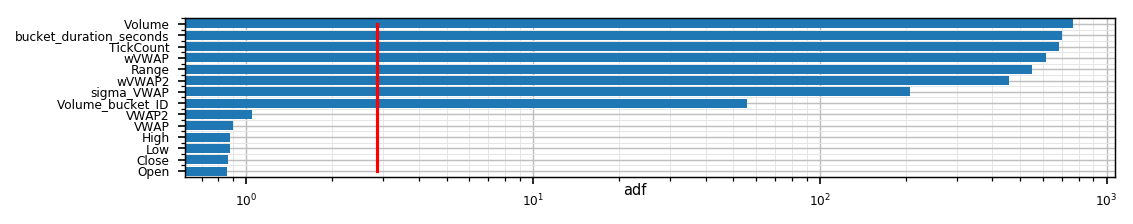

In [11]:
p = bar_plot(adf,
             'column',
             'adf',
             bars_orientation='horizontal',
             order_dict={'x':ordered_cols},
             xlab='',
             figsize=(8, len(ordered_cols)/10),
             fontsize=7)
p['ax'].plot(adf['95%'].tolist(),range(1, len(ordered_cols)+1), 'r')
p['ax'].set_xscale('log')

In [12]:
non_stationary_feats = adf.loc[adf['adf']<adf['95%'],'column'].tolist()

In [13]:
non_stationary_feats

['Open', 'Close', 'Low', 'High', 'VWAP', 'VWAP2']

# Fractional differencing

In [15]:
# init fd obj
fd = FractionalDifferencing(resampled)

2018-07-18 16:30:40,662 - arrow_utils.FeatureEngineering.FractionalDifference.FractionalDifferencing - fracdiff - INFO - d = 0.0: number of non-negligible weights = 1 (0.00% of the time-series lenght)
2018-07-18 16:30:41,422 - arrow_utils.FeatureEngineering.FractionalDifference.FractionalDifferencing - fracdiff - INFO - d = 0.1: number of non-negligible weights = 4076 (0.22% of the time-series lenght)
2018-07-18 16:31:24,936 - arrow_utils.FeatureEngineering.FractionalDifference.FractionalDifferencing - fracdiff - INFO - d = 0.2: number of non-negligible weights = 3382 (0.18% of the time-series lenght)
2018-07-18 16:32:01,732 - arrow_utils.FeatureEngineering.FractionalDifference.FractionalDifferencing - fracdiff - INFO - d = 0.3: number of non-negligible weights = 2275 (0.12% of the time-series lenght)
2018-07-18 16:32:27,506 - arrow_utils.FeatureEngineering.FractionalDifference.FractionalDifferencing - fracdiff - INFO - d = 0.4: number of non-negligible weights = 1458 (0.08% of the tim

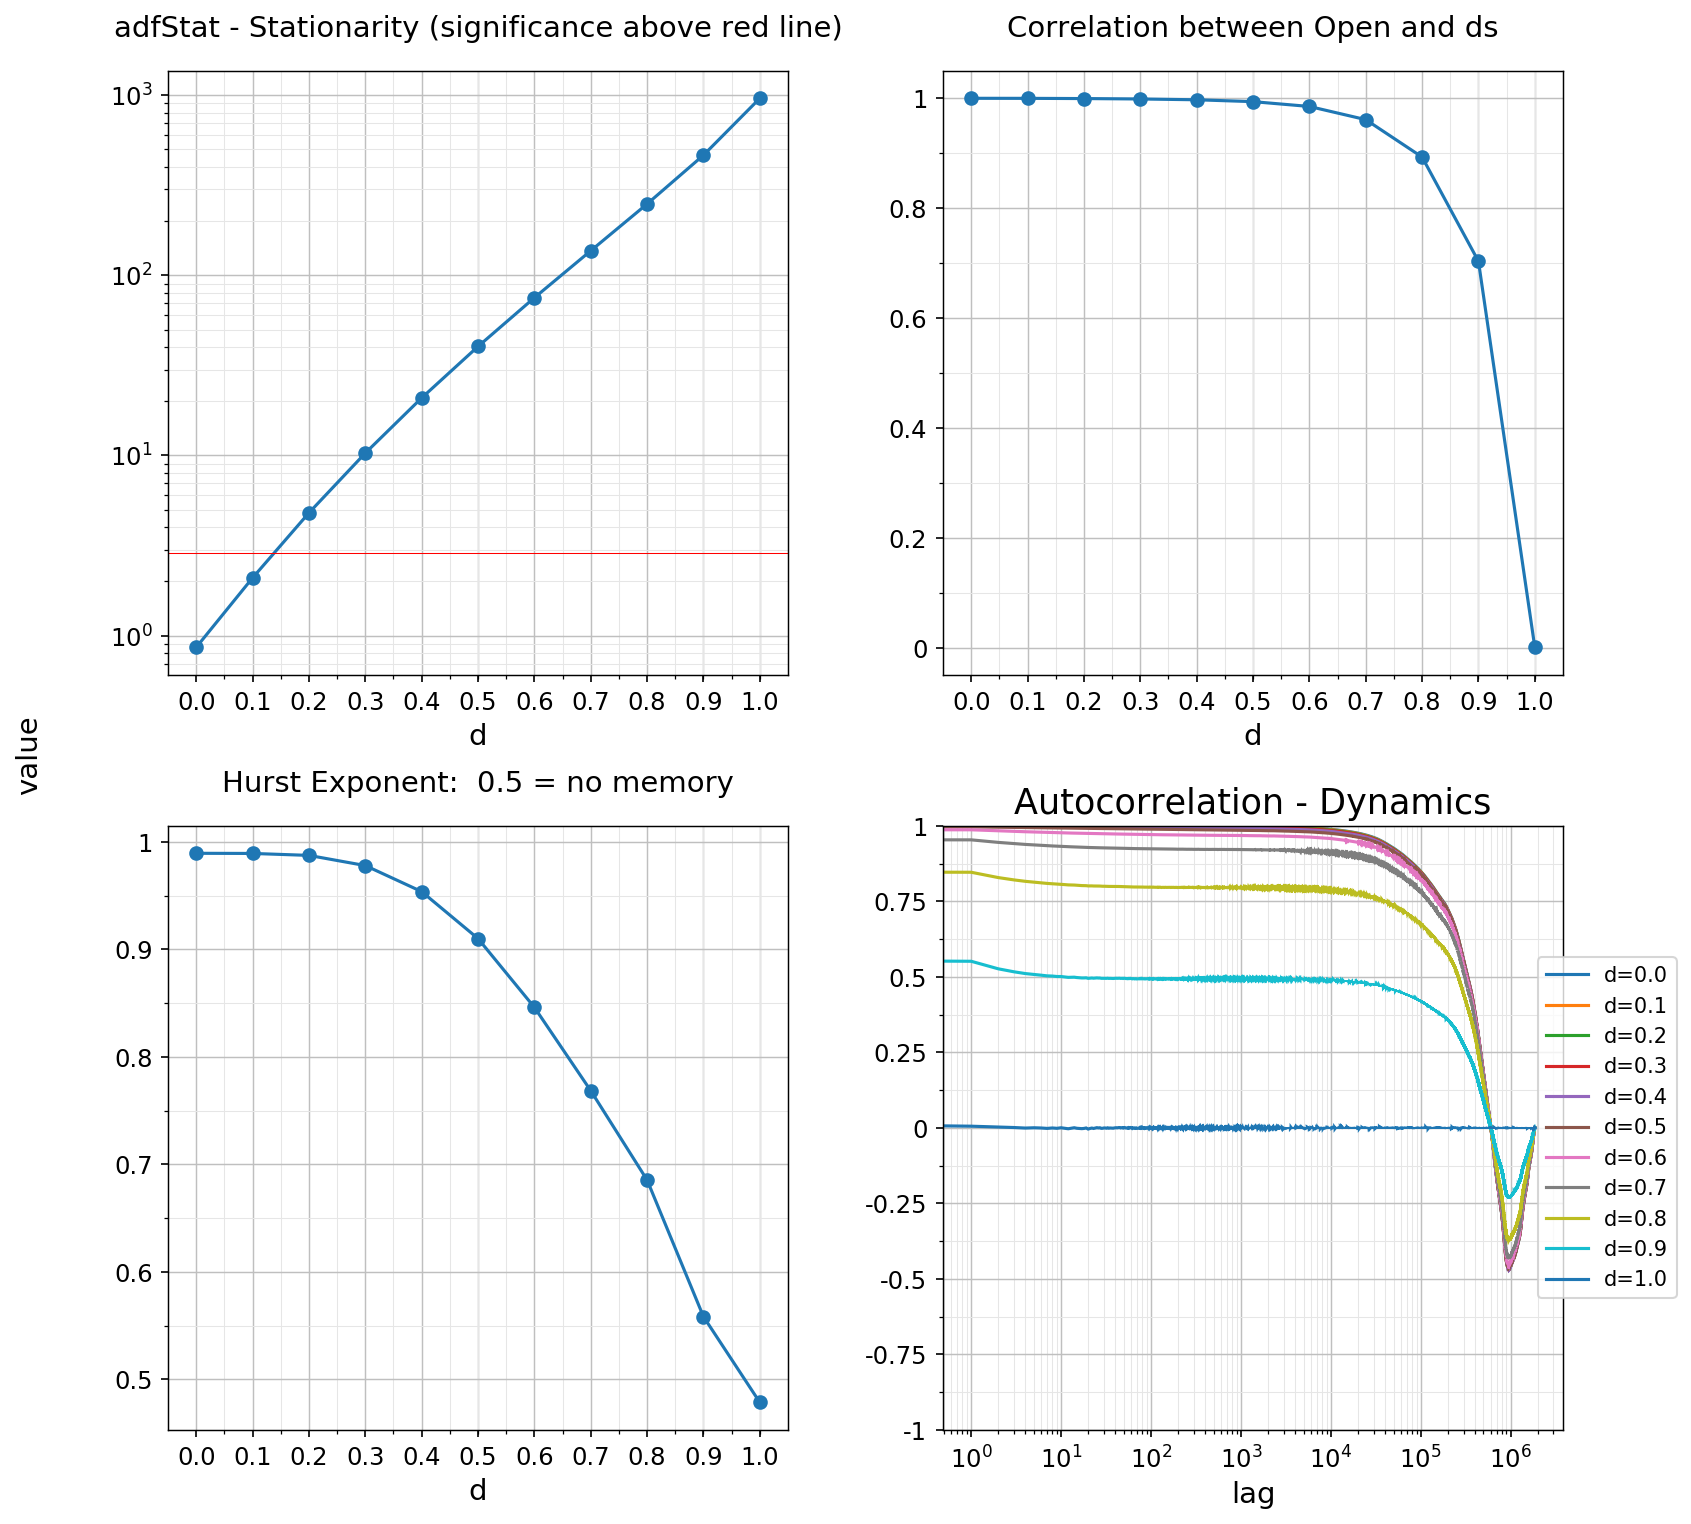

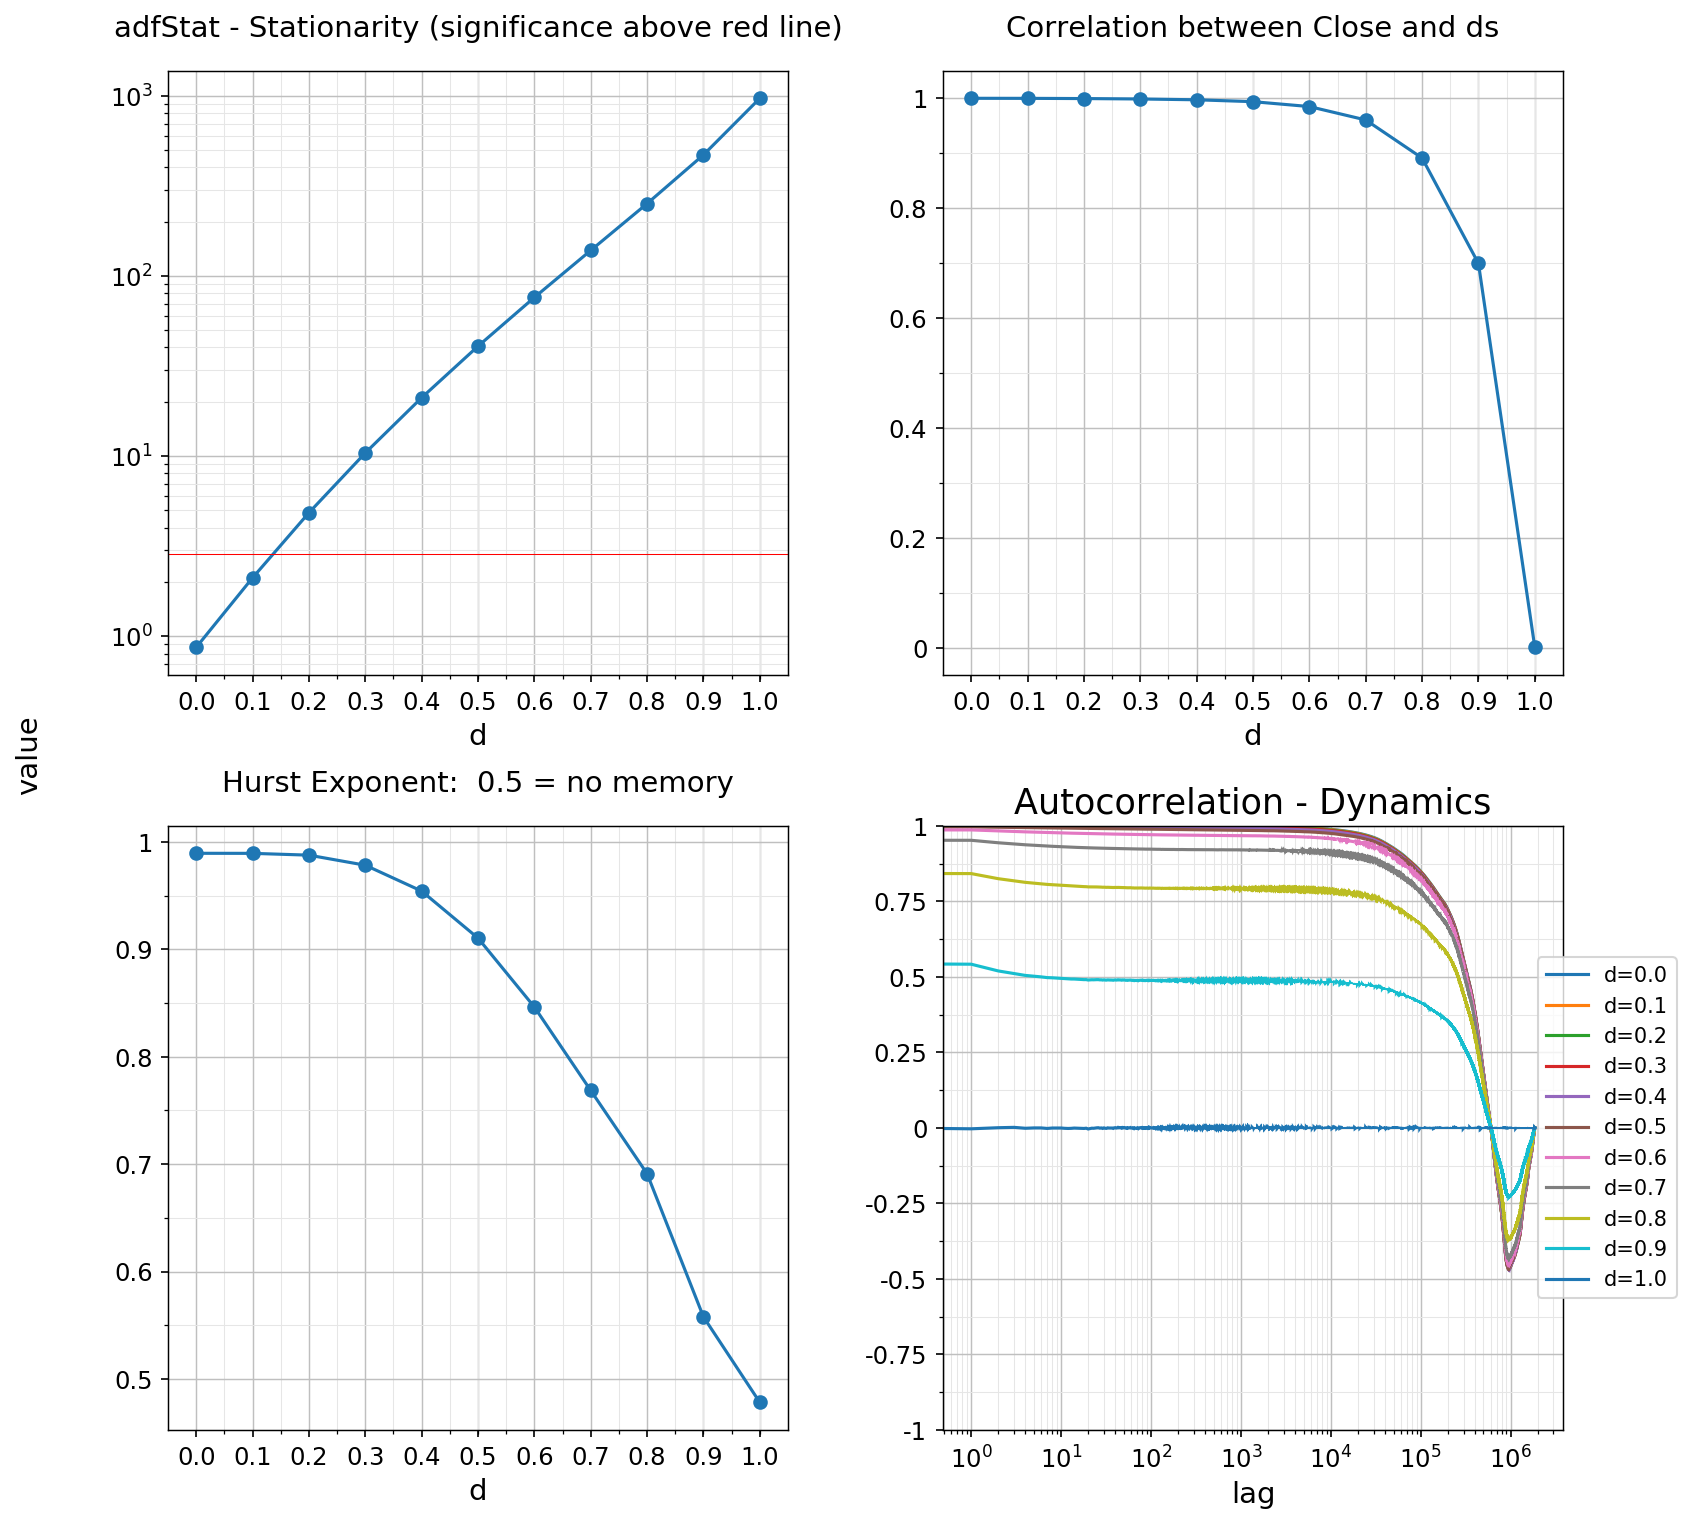

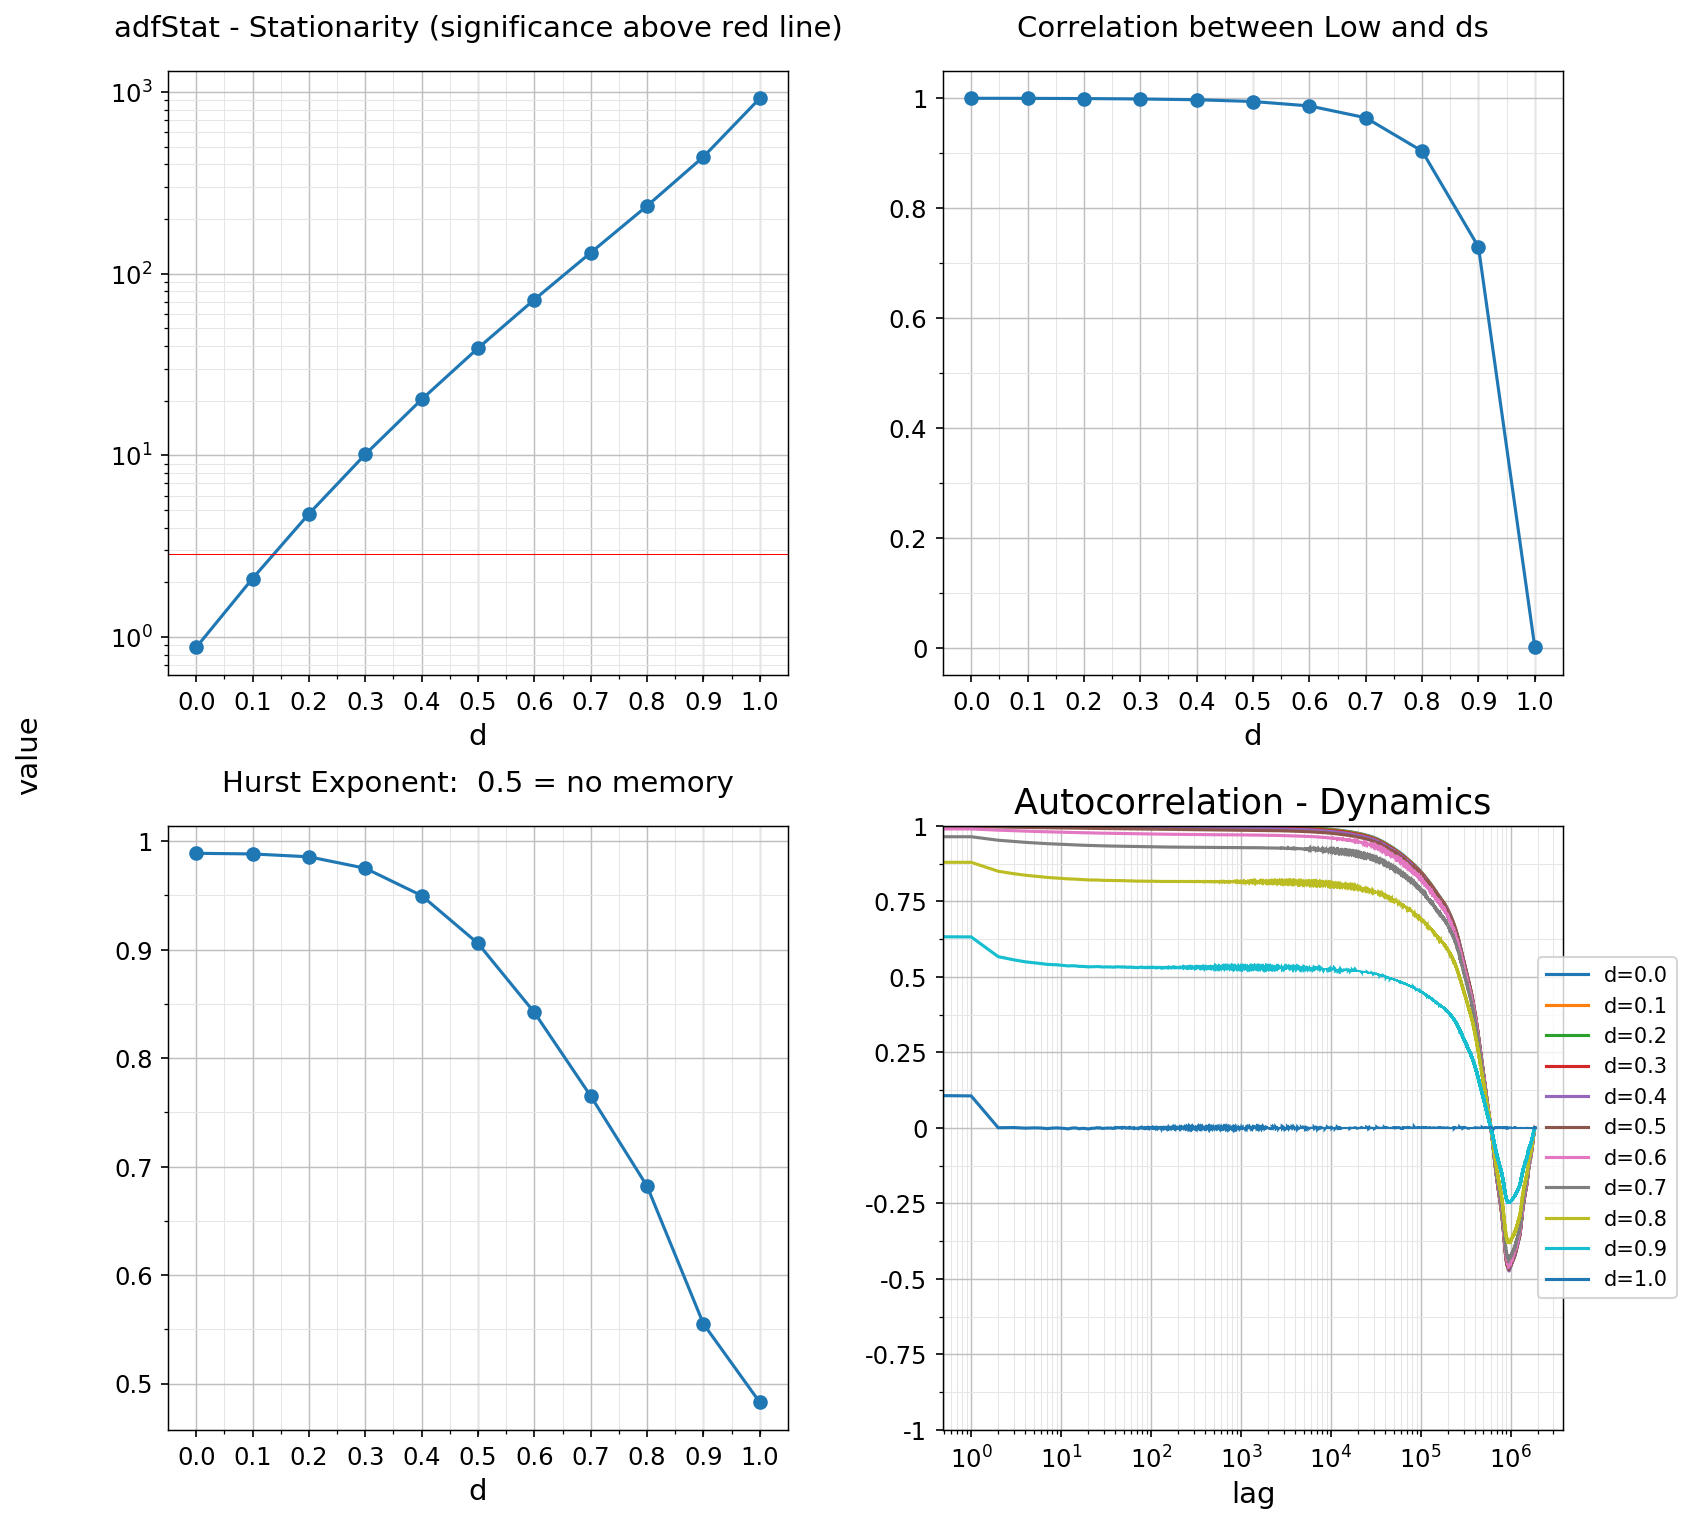

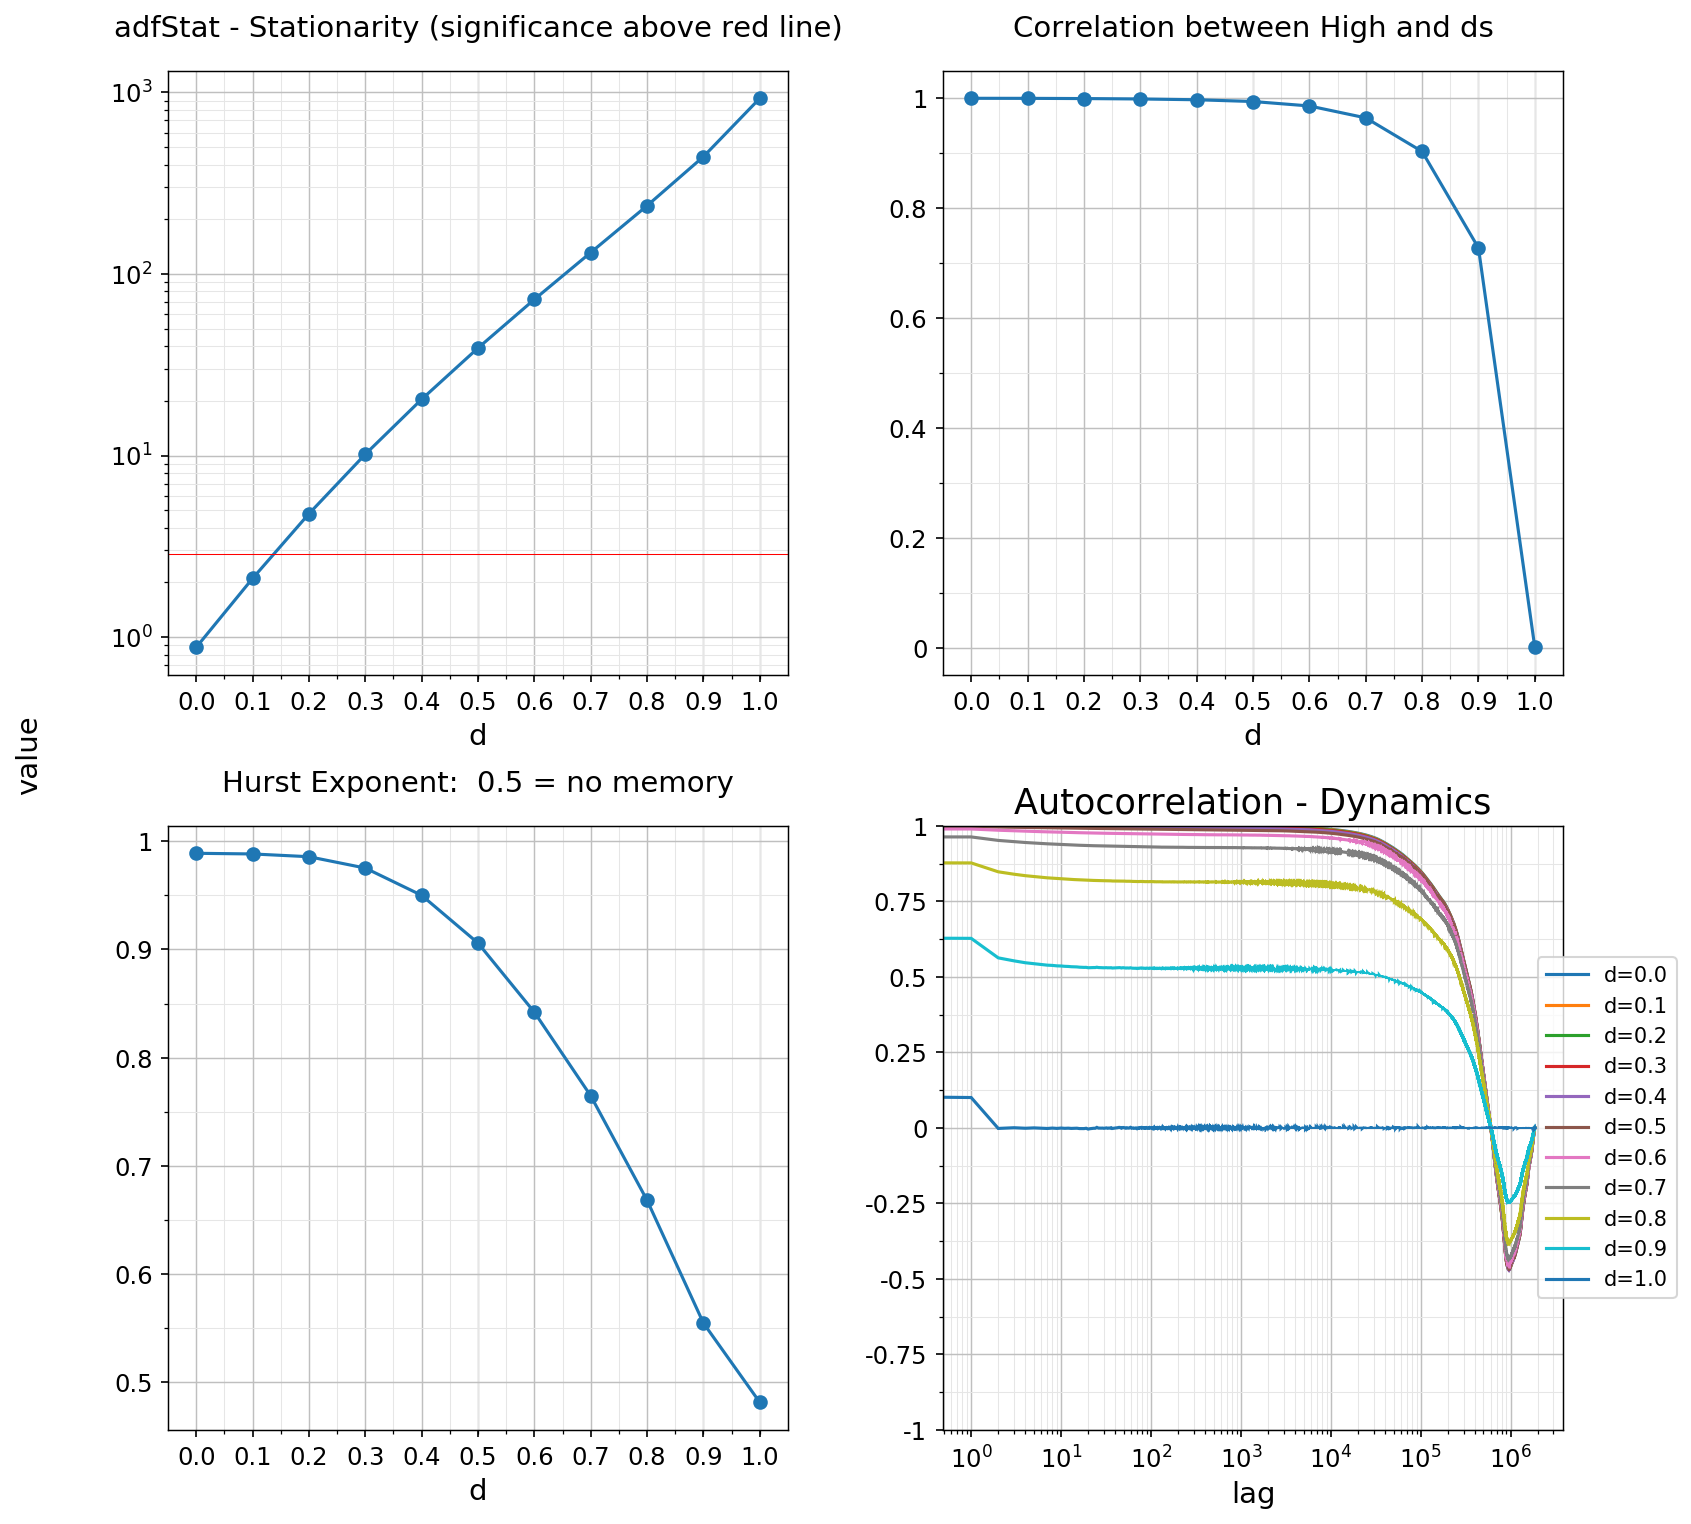

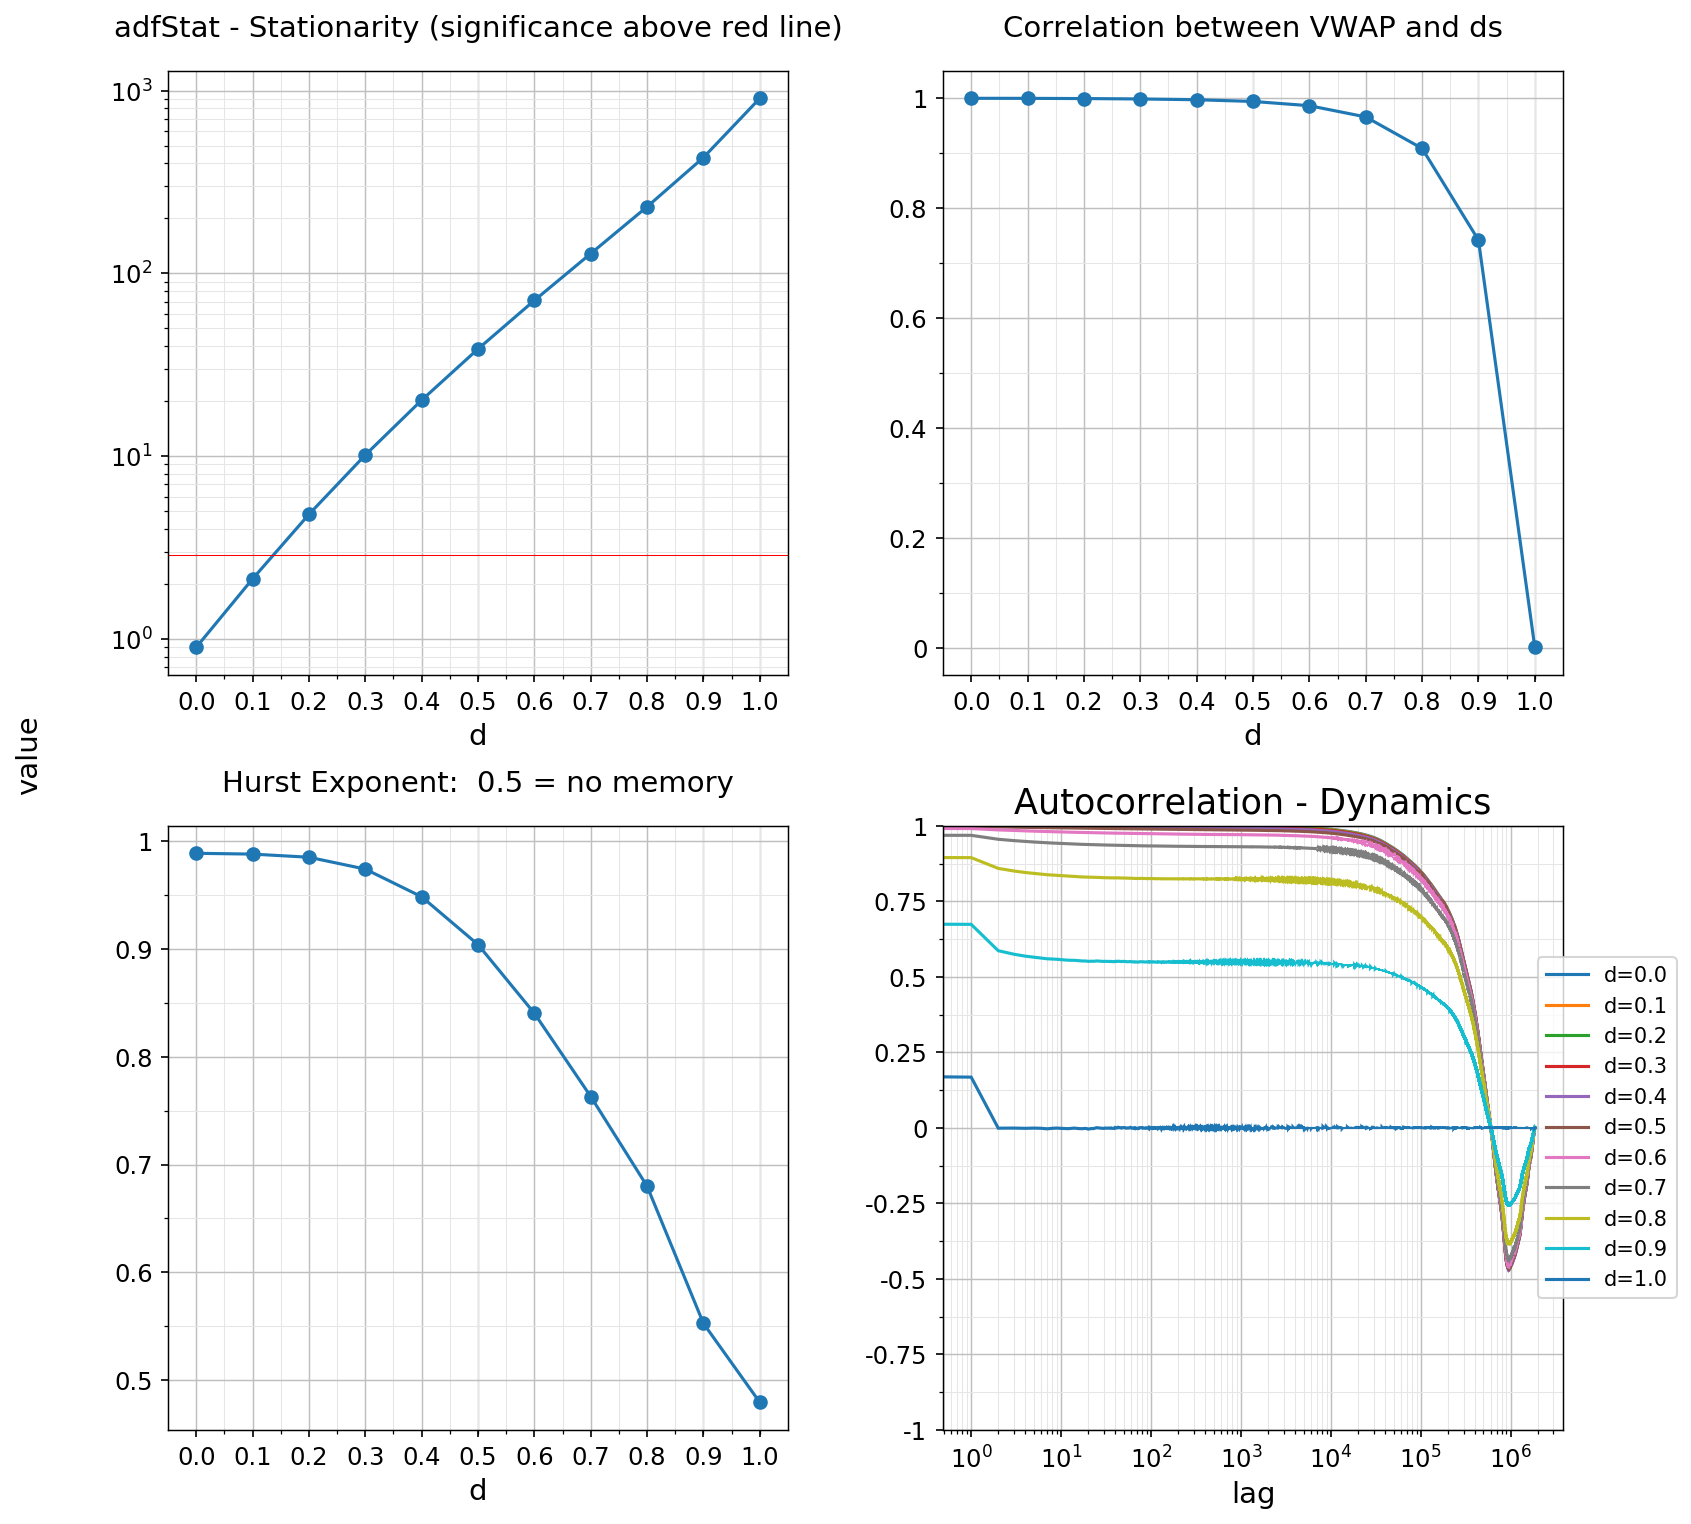

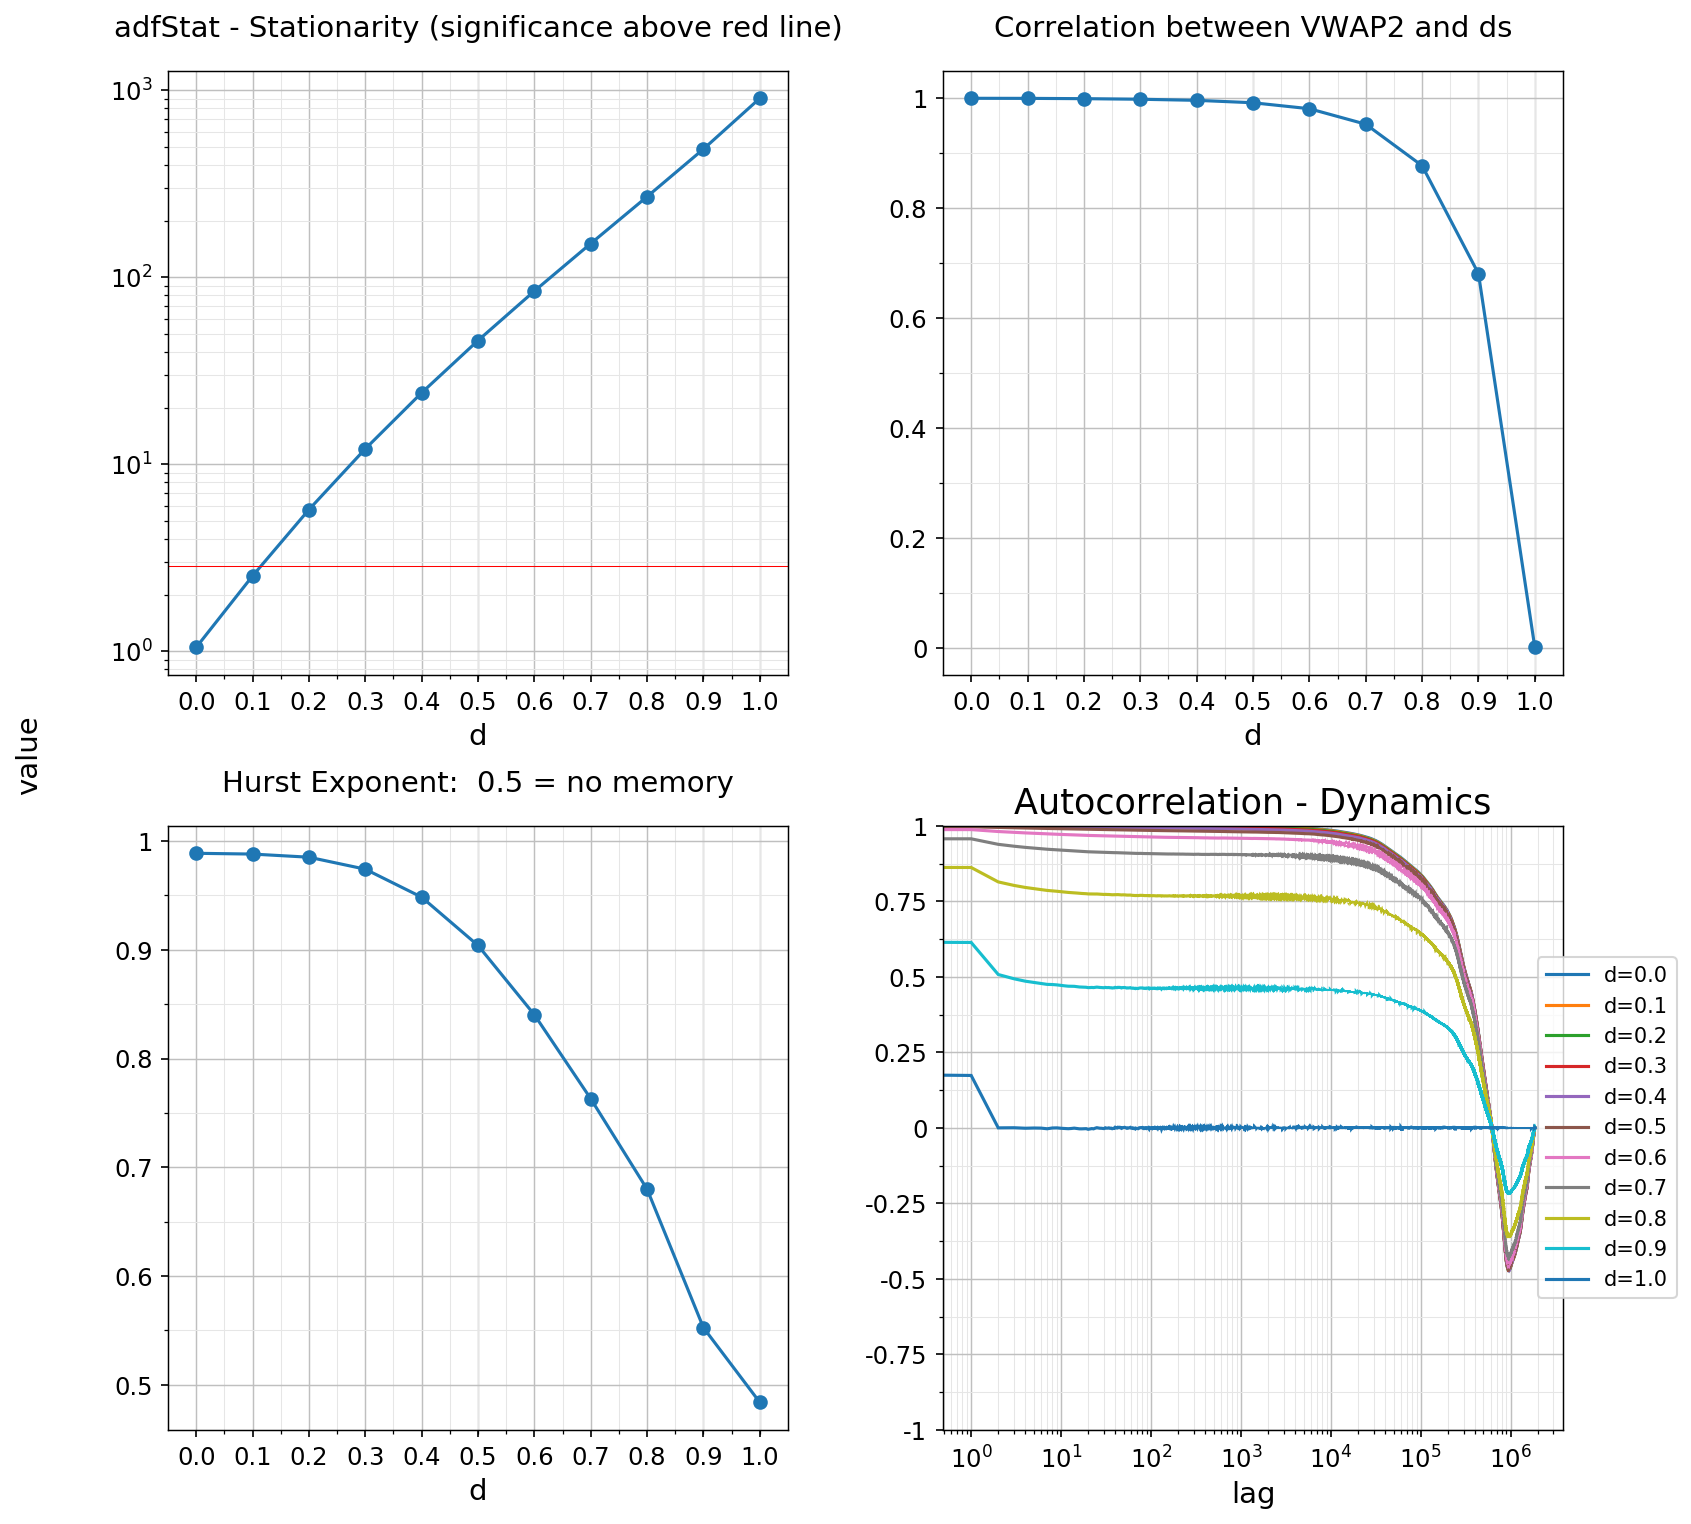

In [16]:
# get optimal d
fd_table = fd.optimal_d(non_stationary_feats)